# DCGAN을 이용한 CIFAR-10 이미지 생성하기

이번 프로젝트에는 이전LMS의 DCGAN 모델구조를 이용해서 CIFAR-10 데이터의 자동차 이미지를 생성하는 모델을  구현해보겠다. (학습데이터가 많아 자동차 이미지로 생성이미지를 한정하였다.)


![d](https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp10/data/result2.png?raw=true)

---


DCGAN(Deep Convolutional Generative Adversarial Networks)이란?
- 기존 GAN의 경우 단순한 이미지에 대해 성능이 좋았지만 cifar10과 같은 복잡한 이미지는 잘생성하지 못하는 점을 개선한 모델
- 입력된 이미지를 바탕으로 그것과 매우 유사한 가짜 이미지를 만들고, 이를 평가하는 과정을 반복하여 실제와 매우 유사한 이미지를 생산하는 학습법
- 생성자와 판별자 네트워크 두 개가 서로 경쟁적으로 학습하는 구조

![d](https://mblogthumb-phinf.pstatic.net/MjAxOTA5MDVfMjQ2/MDAxNTY3Njc3NjMwMTk1.LPzZsZ9wnhnkVXEo9QZYuDHE36Zg_8NqPjg-ga2wsQkg.YGs3MiFHX7rZjsDAs2uVugDKS9p1BbdkKxHql5DzXGgg.PNG.intelliz/dcgan.png?type=w800)


## 라이브러리

In [2]:
import PIL
import imageio
from IPython import display

import glob
import time
import os
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 데이터셋 구성
cifar10 이미지중 label이 1에 해당하는 자동차이미지만 학습데이터로 설정하고 로드한뒤 이미지를 확인해보자.

In [3]:
cifar10 = tf.keras.datasets.cifar10

def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(train_x, train_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

train_x, test_x = load_data(label=1)

170508288/170498071 [==============================] - 3s 0us/step


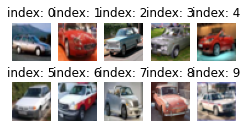

In [4]:
plt.figure(figsize=(4, 2))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [5]:
train_x.shape # L, W, H, C = X_train.shape : L 은 데이터 수, W 이미지 넓이 (y축), H 이미지 높이 (x축), C 이미지 채널 수

(5000, 32, 32, 3)

cifar10 중 자동차 이미지는 5천장이며, 사이즈는 32*32이다. 0에서 255범위의 이미지 픽셀값을 -1에서 1사이로 정규화해준다.

In [6]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [7]:
# train_x 이미지 픽셀 데이터를 정규화 
train_x_nor = (train_x - 127.5)/127.5

print("max pixel:", train_x_nor.max())
print("min pixel:", train_x_nor.min())

max pixel: 1.0
min pixel: -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


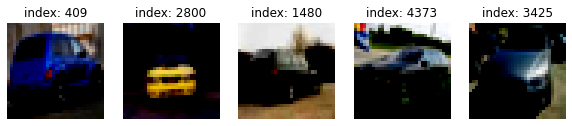

In [8]:
plt.figure(figsize=(10, 12))

for i in range(5):
    plt.subplot(1, 5, i+1)
    random_index = np.random.randint(1, 5000)
    plt.imshow(train_x_nor[random_index].reshape(32, 32,3))
    
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

## 입력파이프라인 구성

BUFFER_SIZE은 전체 데이터를 섞기 위해 5,000으로 설정하고 배치사이즈는 실험에따라 64, 128, 256으로 설정해보았다.

In [10]:
BUFFER_SIZE = 5000 
BATCH_SIZE = 256

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x_nor).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
len(train_dataset) , 5000/BATCH_SIZE #5000을 배치로 나눈값  #train_dataset.shape

(20, 19.53125)

---

# 생성자 모델(Generator) 



- Dense
 - [1, 100] 사이즈의 노이즈(고정된 seed)를 입력으로 받음
 - 정규분포에서 추출한 잠재공간 벡터  

- Reshape
 - 노이즈 벡터의 형상을 (8, 8, 256)로 변경해줌.

- Conv2DTranspose
 - Conv2와 반대로 이미지를 업샘플링함. 
 - 잠재공간 벡터로 하여금 이미지와 같은 차원을 갖도록 변환시켜주는 역할
 - 3개의 Conv2DTranspose층을 거치며 (8, 8, 128) → (16, 16, 64) → (32, 32, 3) 으로 커짐.

- BatchNormalization
 - 안정적 학습을 위해 배치정규화를 적용

- 활성화함수
 - 활성화함수는 LeakyReLU를 사용
 - 최종출력층에는 전처리했던 이미지픽셀 범위(-1\~1)과 동일하게 하기위해 tanh를 사용하여 출력값 조정







In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))# batch_size, 100) 형상의 노이즈 벡터
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second: Reshape layer
    model.add(layers.Reshape((8,8,256)))# 1차원 벡터를 (8, 8, 256) 형상의 3차원 벡터로 변환
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')) #tanh :  -1 ~ 1 이내의 값으로 픽셀 값을 정규화
        
    return model
              

In [14]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

아직 생성자모델을 학습하지 않았지만 노이즈를 적용하여 어떤 이미지를 생성하는지 확인해보자.

(1, 32, 32, 3)


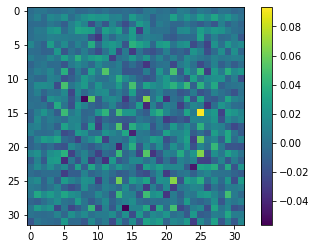

In [15]:
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)
print(generated_image.shape)

plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

[1, 32, 32, 3] 사이즈의 이미지가 생성되는 것을 확인할 수 있다.

---

## 판별자 모델(Discriminator)

- Conv2D 
 - 첫 번째 Conv2D 층에서 입력된[32, 32, 3] 사이즈의 이미지를 입력받음
 - Conv2D 층을 거치며 (32, 32, 3) → (16, 16, 64) → (8, 8, 128)까지 이미지 특징을 추출한다.
 - 특징맵을 줄이기 위해 풀링이 아닌 strides를 사용
 
- Dropout
 - 안정적 학습을 위해 드랍아웃 적용.
 
- Dense 
 - 마지막 출력층 판별결과로 진짜라고 판단하는 정도 표시
 - 0에서 1사이의 확률값을 출력(진짜 이미지의 경우 1에 가까운값, 가짜이미지의 경우 0에 가까운값)
 
- 활성화함수
 - LeakyReLU
 - 특이사항 : 마지막출력층에 판별을 위한 sigmoid를 두지않음. 


In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
     # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))    
    ### If your last layer has 1 output as a binary, then last dimension of Y also should be 1.
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
     # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))        
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(3))
    
    return model
              

In [17]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

역시 판별자 모델이 어떤 값을 출력하는지 확인해보자.

In [18]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.00130191, -0.00253289,  0.00099178]], dtype=float32)>

---

## 손실함수 설정

<img src="https://editor.analyticsvidhya.com/uploads/754471a.png" width="600" height="400"/>

판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용한다.

- BinaryCrossEntropy함수
 - from_logits = True : BinaryCrossEntropy함수 입력 파라미터는 0\~1사이에 분포하는 확률값인데 판별자의 결과의 범위가 정해지지 않았기때문에 여기서 0~1사이값으로 정규화하기위해 설정함.


In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 판별자의 손실함수
판별자는 위 그림처럼 두가지케이스(진짜이미지, 가짜이미지)에 대한 두가지 손실값을 함께 계산해야한다.

판별자의 목표는 실제 이미지에 대한 예측(real_output)값이 1에 가까워지고, 가짜이미지에 대한 예측(fake_output)값은 0에 가까워지기를 바란다.
따라서 real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하여 값을 도출한다.

![ㅇ](https://4.bp.blogspot.com/-wylA3Dm1Fp0/WZkCs8ZqOsI/AAAAAAAAAIk/iLfPdOURNpU3cFgO5hJS4IvZShY6Xxf3ACLcBGAs/s320/math_uf_1502637696846.png)

판별자의 입력 x에 대한 출력 확률을 D(x)라 표현한다면, 진짜 이미지에 대해서는 D(x)를 최대화하고 가짜이미지에 대해서는 D(x)를 최소화해야 하는 것이다.


In [20]:
#판별자의 손실함수
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 생성자의 손실함수

생성자의 손실함수는 판별자를 얼마나 잘 속였는지를 손실값으로 계산한다. 즉, 자신이 만든 가짜이미지로 판별자에게 높은 출력값을 받아야하므로 예측(fake_output)값을 1과 비교한다.

![ㅇ](https://3.bp.blogspot.com/-6IN75cmdWVE/WZkEzUiWlKI/AAAAAAAAAIw/mznaMQ-HMqEyj25Zem_zsjl3Zk8nqot8gCLcBGAs/s1600/math_uf_1503200291208.png)

노이즈를 생성자가 변환시킨 결과를 G(z)라고 하고 판별자가 가짜이미지를 입력으로 받아 출력하는 확률은 D(G(z))로 표기한다면
생성자는 G(z)를 가짜라고 판별할 확률 1-D(G(z))를 최소화하는 것이 목표이다. D(G(z))을 1로 이루어진 행렬과 비교하는 이유이다.
 

In [21]:
#생성자의 손실함수
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 정확도 함수 설정

판별자 모델의 성능을 파악을 위해 정확도 함수도 추가해준다. 판별자가 진짜이미지와 가짜이미지를 얼마나 잘 판별하는지는 accuracy를 보고 알 수 있을 것이다. 


In [22]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 최적화 함수

- 최적화 함수는 일반적으로 GAN에서 많이 쓰이는 Adam 을 적용했다. 
- 이전보다는 조금 더 정교하게 옵티마이저를 사용해야하기위해 학습률과 베타값을 조정했다. 
 - lr : 0.0001 -> 0.0002, beta_1=0.5

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

---

# 생성적 적대 신경망(GAN) 


필요한 파라미터 및 랜덤시드를 설정해 주겠다. 생성자 모델의 경우 노이즈 데이터가 필요한데 정규분포를 가지는 16장의 이미지를 사용하되 테스트를 위해 매번 고정되 seed를 사용하도록하겠다.


In [24]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

GAN 모델훈련에 앞서 학습및 학습상태확인을 위한 함수 및 변수들을 정의 합니다.

- train_step : 미니 배치별 학습 함수
- generate_and_save_images : 16개의 고정된 seed로 생성된 노이즈값으로 훈련 과정 동안 생성한 이미지를 시각화하는 함수
- draw_train_history : 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 real/fake 이미지 판별 accuracy 히스토리(history)를 시각화하는 함수
- training_checkpoints : 지정한 epoch마다 모델을 저장하는 checkpoint 모듈


## 미니 배치별 학습 함수

- 처리 흐름
```
(1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
(7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴
```


In [25]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습 - 학습된 모델 파라미터 갱신
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### 생성이미지 시각화
16개의 고정된 seed로 생성된 노이즈값으로 훈련 과정 동안 생성한 이미지를 시각화하는 함수

In [36]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False) # training=False (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
    
    plt.savefig('{}/aiffel/project/exp10_GAN/newimage/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### Loss, Accuracy 시각화

- train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 값으로 매 epoch마다 시각화
- 에폭 50회마다, 또는 학습 마지막에 시각화 이미지 저장

In [27]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch, bLast):
    # summarize history for loss  : 판별자와 생성자의 손실값 history
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  : 판별자와 생성자의 정확도 history
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    if epoch%50 == 0 | bLast :
        plt.savefig('{}/aiffel/project/exp10_GAN/newimage/training_history/train_history_{:04d}.png'
                        .format(os.getenv('HOME'), epoch))
    plt.show()

모델 학습이후 테스트를 위해 모델 저장할때 이용

In [28]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/project/exp10_GAN/newimage/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

---
# GAN 모델 학습

위에 구현한 생성자, 판별자 모델과 학습을 위해 정의한 함수들을 이용해 학습을 진행해보자.

In [29]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))
        
        #학습결과 - 손실, 정확도 시각화
        draw_train_history(history, epoch, False)
    
    draw_train_history(history, epoch, True)   
    

In [49]:
save_every = 50 # 모델저장 간격
EPOCHS = 1500    # 학습횟수

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

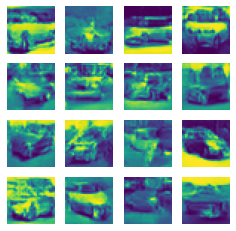

Time for training : 4856 sec


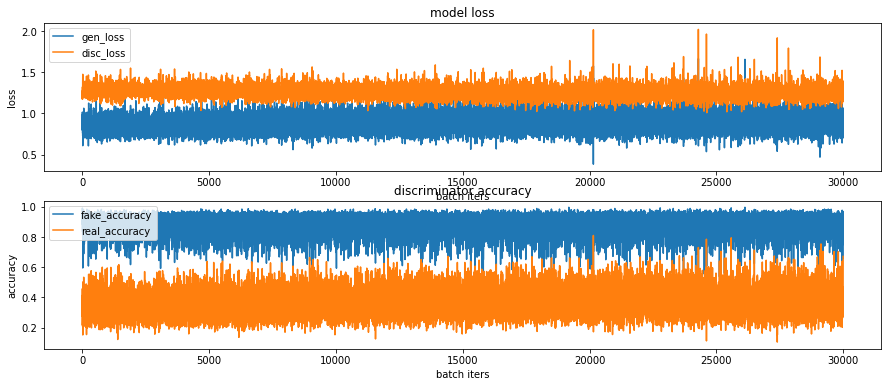

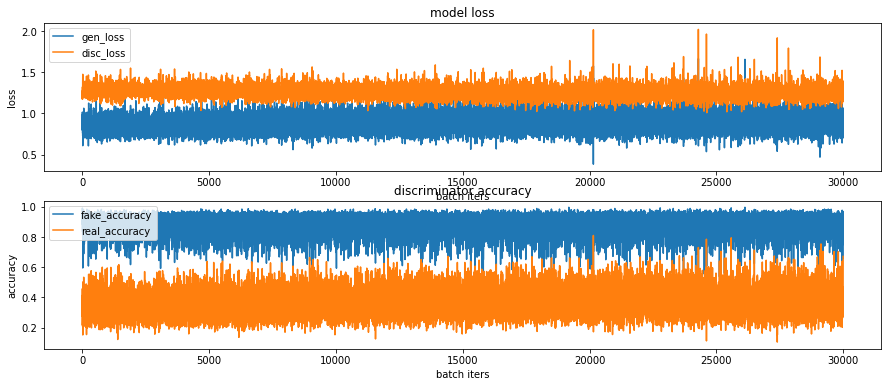

CPU times: user 1h 28min 1s, sys: 13min 16s, total: 1h 41min 17s
Wall time: 1h 20min 59s


In [50]:
%%time
#with tf.device('/GPU:0'):
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/project/exp10_GAN/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

## checkpoint모듈로 이미지 생성하기

checkpoint를 통해 학습이 완료된 모델 로드하여 노이즈값에 대해 자동차 이미지를 생성해주는지 확인해보자.

In [60]:
noise_test = tf.random.normal([1, 100])

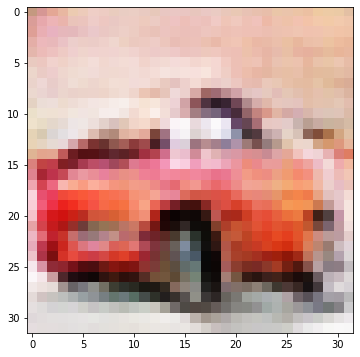

In [111]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/project/exp10_GAN/newimage/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest) #마지막 체크포인트를 복구

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise_test = tf.random.normal([1, 100])
generated_image = generator(noise_test, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

---
## 학습에 대한 결과

- 유관상 가장 자동차 이미지로 가장 잘보이는 경우는 모델의 학습횟수를 늘리는 것이였다. 아래 이미지는 epoch횟수를 200-> 600-> 1000회로 했을때의 생성한 이미지의 변화이다.

![d](https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp10/data/result.png?raw=true)

모델의 학습이 진행되면서 생산자모델이 생성한 자동차의 외각 라인을 좀더 선명하게 나타나는것을 알수 있다.   1000회 학습시 생성자 모델의 로스값도 점점 내려가고 있고 판별자의 정확도의 경우도 가짜라고 판단하는 경우가 0.7로 줄어들 케이스도 많아 보인다.

- epochs 600 회 손실, 정확도 그래프

<img src="https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp10/data/acc_epoch600.png?raw=true" width="600" height="300"  />

- epochs 1000 회 손실, 정확도 그래프

<img src="https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp10/data/acc_epoch1000.png?raw=true" width="600" height="300"  />

하지만 여전히 판별자 우위의 학습진행 양상(판별자의 loss가 더 낮음)을 보이고 있어서 생성자가 제대로된 이미지를 생성하기위해 많은 개선이 필요할 것같다. 지금까지 해보았던 학습 1000회에서 로스가 줄고 있어서 학습회수를 1500회까지 늘려서 진행해보았다.(결과는 위 train 함수 실행부분참조)



---
## 모델 개선을 위한 실험

epoch 500회를 기준으로 하여 하이퍼 파라미터들을 변경하거나 모델 구조를 변경해보았다. 

- 필터 사이즈 변경  :  5-> 3
 - 필터사이즈를 작게변경하니 판별자가 생성자의 가짜이미지를 잘 판단하여 생성자는 좋은 성능을 가지지 못했다. 

<table border="1">
	<tr>
	    <td><img src="https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp10/data/05_ver5_filter3_epoch500.png?raw=true" width="600" height="300"  /></td>
	    <td><img src="https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp10/data/ver5%20epoch%20500%20%EB%B0%B0%EC%B9%98%EC%82%AC%EC%9D%B4%EC%A6%88%20128%20%ED%95%84%ED%84%B0%203%20%EC%8A%A4%ED%8A%B8%EB%9D%BC%EC%9D%B4%EB%93%9C%203.png?raw=true|" width="200" height="200"  /></td>
</tr>	
</table>
 

- 배치 사이즈 변경  : 256-> 128
 - 이경우 역시 필터 사이즈를 줄인것과 비슷하게 학습되는 양상이다.
<table border="1">
	<tr>
	    <td><img src="https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp10/data/04_128_BN_500epoch.png?raw=true" width="600" height="300"  /></td>
	    <td><img src="https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp10/data/ver4%20epoch%20500%20%EB%B0%B0%EC%B9%98%EC%82%AC%EC%9D%B4%EC%A6%88%20128.png?raw=true" width="200" height="200"  /></td>
</tr>	
</table>
 
- **학습률(learning rate) 변경 : 1e-4 -> 0.0002, beta_1=0.5**
 - 학습률을 변경한것은 기존과 다른 학습패턴을 보였는데 생성자의 손실값이 판별자보다 더 낮게 나왔으며 판별자가 진짜이미지에 대해 판별하는 정확도가 떨어졌다. 이것은 생성자가 만든 가짜 이미지가 영향을 준것이 아닌가 한다. 실제 훈련이미지를 시각화한 경우 차체의 외곽 라인과 음영부분은 좀더 드러나는 것을 확인할수 있었다.
 
<table border="1">
	<tr>
	    <td><img src="https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp10/data/ver07_lr_0.0002%EB%B3%80%EA%B2%BD_%EB%B0%B0%EC%B9%98%20256%20graph.png?raw=true" width="600" height="300"  /></td>
	    <td><img src="https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp10/data/ver07_lr_0.0002%EB%B3%80%EA%B2%BD_%EB%B0%B0%EC%B9%98%20256.png?raw=true" width="200" height="200"  /></td>
</tr>	
</table>
 

---
## 정리

이번프로젝트는 GAN을 통해 서로 지향하는 목표가 적대적인 두 모델을 훈련해보았다. 관련하여 각 모델의 목표에 맞게 손실함수를 정의해주었는데 지금까지 compile함수에 loss를 지정만해주다가 따로 손실함수를 구현해보니 왜 그렇게 구현이 되는지 이해하기가 아주 어려웠다. 

머신러닝이 작동하는 원리는 손실함수를 줄이기 위해서이기 때문에 손실함수에 대한 이해가 필수적인것 같다. 막연히나마 손실함수를 어떻게 정의하고 어떻게 모델에 적용이 되는지 알수 있었다. 

또한 생성자 모델이 노이즈값을 의미있는 이미지로 출력하는 부분이 아주 흥미로웠다. 많은 컴퓨팅 파워가 필요하지만 학습을 통해 생성자가 조금씩 이미지를 보완해 나가는 것이 신기했다. 마지막으로 생성자 모델을 체크포인트로 로드하여 생성한 자동차 이미지의 변화를 확인해보자. (마지막 이미지의 생성자 모델 : epoch 1500회, 배치 256, 학습률 조정)

![d](https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp10/data/result2.png?raw=true)

---
## Reference
- [[GAN] 적대적 학습](http://dl-ai.blogspot.com/2017/08/gan-adversarial-learning.html)
- [GAN 손실함수](https://yuhodots.github.io/deeplearning/20-04-22/)
- [TF Tutorial](https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko)
- [dcgan tutorial](https://colab.research.google.com/github/9bow/PyTorch-Tutorials-kr/blob/master/docs/_downloads/52d07bf9e7a1a21004b361865bd6290f/dcgan_faces_tutorial.ipynb#scrollTo=qWrPAcOiMnUM)
